In [1]:
import pandas as pd
import numpy as np




In [1]:
import wandb
api = wandb.Api()

In [2]:
import pandas as pd
def load_runs(project):
    runs = api.runs("hynky/Server-Deep-Learning")
    runs_filtered = [run for run in runs if run.name in models]
    return runs_filtered


def prepare_runs(runs, metrics):
    # join into one dataframe
    df = None
    for run in runs:
        keys = metrics + ["trainer/global_step"]
        run_hist = run.scan_history(keys=keys)
        run_df = pd.DataFrame(run_hist)
        name = run.name
        run_df = run_df.rename(columns={"trainer/global_step": "step"})
        # join on step
        if df is None:
            df = run_df
        else:
            df = df.merge(run_df, on="step", how="outer")
    return df

def adjust_val(df):
    # add row empty row for val
    # sort by step
    df = df.sort_values(by="step")
    new_row = df.iloc[0].copy()
    new_row["step"] = df["step"].max() + 1
    df = df.append(new_row, ignore_index=True)
    return df


def prepare_for_plot(df, metric):
    x = df["step"]
    y = df[metric]
    # remove nan
    y = y[~np.isnan(y)]
    x = x[~np.isnan(y)]
    return x, y


In [16]:
df =prepare_runs(load_runs("hynky/Server-Deep-Learning"), ["val/loss_epoch"])

NameError: name 'api' is not defined

In [155]:
df["RobeCzech-Base - val/loss_epoch_epoch"][0] = df["RobeCzech-Base - val/loss_epoch"][0]
df = df.drop(columns=["RobeCzech-Base - val/loss_epoch"])
df = df.rename(columns={"RobeCzech-Base - val/loss_epoch_epoch": "RobeCzech-Base - val/loss_epoch"})
df.to_csv("resources/day_val_loss.csv", index=False)

/tmp/ipykernel_57679/999666273.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["RobeCzech-Base - val/loss_epoch_epoch"][0] = df["RobeCzech-Base - val/loss_epoch"][0]


In [17]:
def prepare_for_plot(df, metric):
    if "trainer/global_step" in df.columns:
        df = df.rename(columns={"trainer/global_step": "step"})
    if "Step" in df.columns:
        df = df.rename(columns={"Step": "step"})
    worng_metrics = [col for col in df.columns if col.endswith(f"{metric}_epoch")]
    for col in worng_metrics:
        orig_metric = col.replace("_epoch", "")
        if orig_metric in df.columns:
            df[orig_metric][0] = df[col][0].copy()
            df = df.drop(columns=[col])
        else:
            df = df.rename(columns={col: orig_metric})
    
    needed_cols = [col for col in df.columns if col.endswith(metric)] + ["step"]
    df.drop(columns=[col for col in df.columns if col not in needed_cols], inplace=True)
    df = df.sort_values(by="step")

    return df

df = pd.read_csv("resources/day_val_loss.csv")
prepare_for_plot(df, "val/loss_epoch")

,step,Fernet-Small - val/loss_epoch,Robeczech-Small - val/loss_epoch,Fernet-Base - val/loss_epoch,Grad-12 - val/loss_epoch,Grad-24 - val/loss_epoch,LM-tune - val/loss_epoch,Truncate - val/loss_epoch
0,0,NaN,NaN,1.686713,1.688815,1.688358,1.679747,1.683445
1,1041,1.921231,1.924358,NaN,NaN,NaN,NaN,NaN
2,1440,NaN,NaN,NaN,NaN,NaN,NaN,1.881565
3,1451,NaN,NaN,NaN,1.924088,NaN,NaN,NaN
4,2083,NaN,1.882810,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
116,57615,NaN,NaN,NaN,1.685551,NaN,NaN,NaN
117,57635,NaN,NaN,NaN,NaN,NaN,NaN,1.696064
118,57636,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119,57637,NaN,NaN,1.687245,NaN,NaN,1.683841,NaN


In [18]:
import numpy as np
# f
def plot(fig, df, smooth=1):
    for col in df.columns:
        if col == "step":
            continue
        x = df["step"]
        y = df[col].astype('float')
        x = x[~np.isnan(y)]
        y = y[~np.isnan(y)]
        # get last value
        y.iloc[-1] = y.iloc[0]
        if len(y) >= 2:
            y = y[1:]
            x = x[1:]

        # Smooth all but the last value
        if len(y) >= smooth:
            y_roll = y.rolling(smooth).mean()[smooth-1:]
            # add start values not smoothed
            y_roll = y.iloc[:smooth-1].append(y_roll)


            y_roll.iloc[-1] = y.iloc[-1]
            y = y_roll

        name = col
        fig.plot(x, y, label=name)
        # dot last value
        fig.scatter(x.iloc[-1], y.iloc[-1], label=name, marker="o", s=20)

In [34]:
models = sorted(["LM-tune", "Grad-12", "Grad-24", "Truncate", "RobeCzech-Base", "Fernet-Base", "Final", "RobeCzech-Small", "Fernet-Small"])
rename = {
    "RobeCzech-Base": "R-Base",
    "RobeCzech-Small": "R-Small",
    "Fernet-Base": "F-Base",
    "Fernet-Small": "F-Small",
    "Truncate": "Truncate",
    "Grad-12": "Grad-12",
    "Grad-24": "Grad-24",
    "LM-tune": "LM-Tune",
}
def filter_models(df, models):
    names = {col:col.split(" - ")[0].strip() for col in df.columns if col != "step"}
    df = df.rename(columns=names)
    # Do intersection of models and columns but keep models order
    intrsecton = [model for model in models if model in df.columns]
    selected = df[["step"] + list(intrsecton)]
    renames = {col:rename[col] for col in selected.columns if col in rename}
    selected = selected.rename(columns=renames)
    return selected

In [66]:
import matplotlib.pyplot as plt
def plot_all(models, smooth=1):

    with plt.style.context(['seaborn-notebook']):
        plt.rcParams['font.family'] = 'Libertinus Sans'
        fig, axs = plt.subplots(2, 2, figsize=(10, 8))
        # set font size for fig
        # set space between subplots
        fig.subplots_adjust(hspace=0.3, wspace=0.3)

        label_map = {
            "cat": "Category",
            "gender": "Gender",
            "server": "Server",
            "day": "Day Of Week"
        }

        # set font to libertinus
        for i,task in enumerate(["cat","gender", "server", "day"]):
            df = pd.read_csv(f"resources/{task}_val_macro.csv")
            df = prepare_for_plot(df, "val/f1_macro")
            df = filter_models(df, models)
            # sort columns
            ax = axs[i//2, i%2]
            plot(ax , df, smooth=smooth)
            ax.set_title(label_map[task])
            ax.set_xlabel("Step")
            ax.set_ylabel("F1 Macro")
        # legend has outside

        handles,labels = ax.get_legend_handles_labels()
        # Take every second item.
        handles = handles[::2]
        labels = labels[::2]
        # set font family to libertine
        fig.legend(handles, labels ,loc='upper center', bbox_to_anchor=(0.5,0), fancybox=True, shadow=True, ncol=5, prop={'family': 'Libertinus Sans'})

        fig.show()
    return fig, axs





/tmp/ipykernel_49920/15871801.py:21: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_roll = y.iloc[:smooth-1].append(y_roll)
/tmp/ipykernel_49920/15871801.py:21: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_roll = y.iloc[:smooth-1].append(y_roll)
/tmp/ipykernel_49920/15871801.py:21: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_roll = y.iloc[:smooth-1].append(y_roll)
/tmp/ipykernel_49920/233093303.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[orig_metric][0] = df[col][0].copy()
/tmp/ipykernel_49920/15871801.py:21: FutureWa

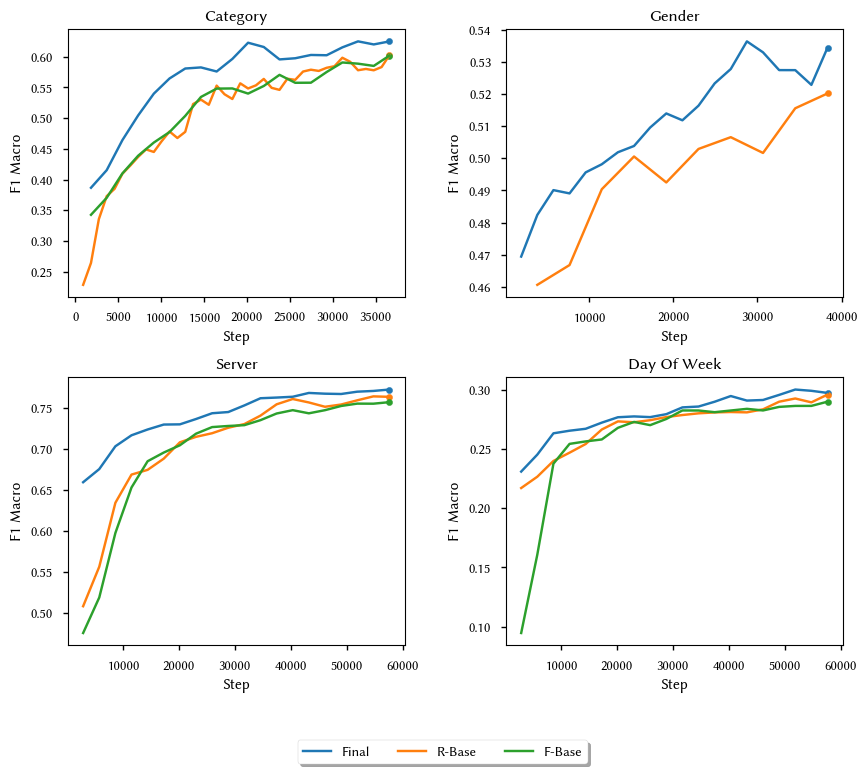

In [67]:
# plot_all(["RobeCzech-Base", "RobeCzech-Small", "Fernet-Base", "Fernet-Small"])
fig,axs = plot_all(["Final", "RobeCzech-Base", "Fernet-Base"], smooth=2)
# save fig
fig.savefig("outputs/base.pdf", bbox_inches='tight')


/tmp/ipykernel_49920/15871801.py:21: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_roll = y.iloc[:smooth-1].append(y_roll)
/tmp/ipykernel_49920/15871801.py:21: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_roll = y.iloc[:smooth-1].append(y_roll)
/tmp/ipykernel_49920/15871801.py:21: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_roll = y.iloc[:smooth-1].append(y_roll)
/tmp/ipykernel_49920/15871801.py:21: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_roll = y.iloc[:smooth-1].append(y_roll)
/tmp/ipykernel_49920/15871801.py:21: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future versi

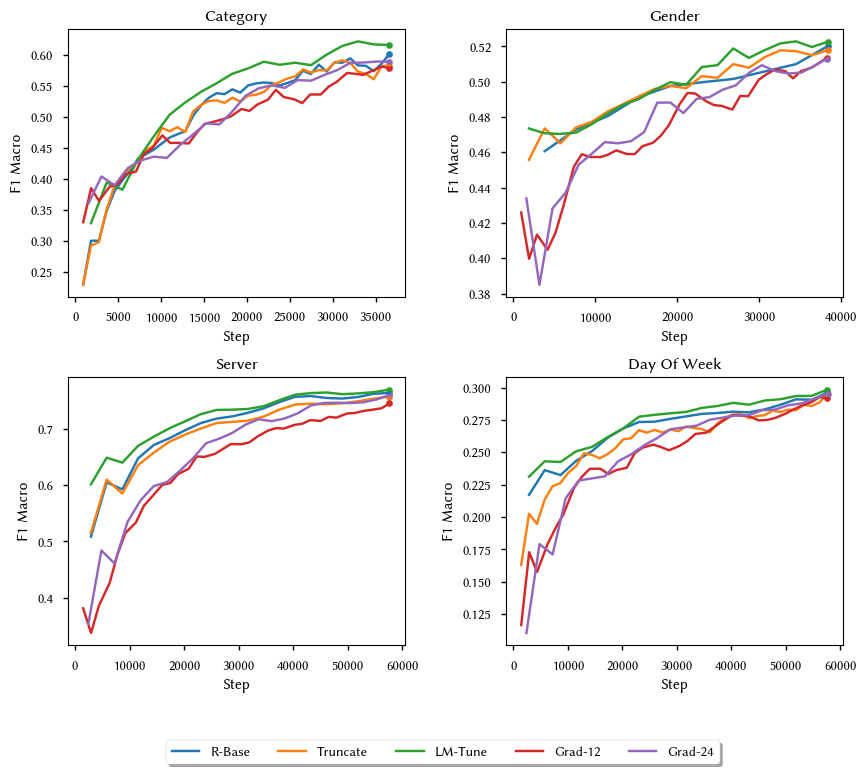

In [68]:
fig, axs = plot_all(["RobeCzech-Base", "Truncate", "LM-tune", "Grad-12", "Grad-24"], smooth=3)
# save fig
fig.savefig("outputs/tune.pdf", bbox_inches='tight')